In [52]:
import pathlib

import torch
import hydra
import polars as pl
from torch.utils import data
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

from recs_utils.neural_network.dataset import UserDataset, ItemDataset
from recs_utils.utils import load_pickle
from recs_utils.neural_network.model import NeuralNetRecommender

In [3]:
with hydra.initialize("configs", version_base="1.3"):
    training_config = hydra.compose("nn_rec", return_hydra_config=True)

In [4]:
exp_dir = pathlib.Path(training_config.hydra.run.dir)
del training_config

In [5]:
checkpoint_dir = exp_dir / "checkpoints"
config = exp_dir / ".hydra" / "config.yaml"

In [6]:
with hydra.initialize(str(config.parent), version_base="1.3"):
    exp_config = hydra.compose("config")

In [7]:
data_dir = pathlib.Path(exp_config.data_dir)

In [8]:
all_item_features = pl.read_parquet(data_dir / "features" / "items.parquet")

In [9]:
test_interactions = pl.read_parquet(data_dir / "interactions" / "test_inter.parquet")

In [10]:
feature_dir = pathlib.Path(exp_config.feature_dir)

In [11]:
user_features_nn = pl.read_parquet(feature_dir / "user_features.parquet")

In [12]:
item_features_nn = pl.read_parquet(feature_dir / "items.parquet")

In [13]:
user_encoder = load_pickle(exp_dir / "user_encoder.pickle")
item_encoder = load_pickle(exp_dir / "item_encoder.pickle")

In [14]:
user_dataset = UserDataset(user_features_nn.join(test_interactions.select(pl.col("user_id").unique()), on=["user_id"]), user_encoder)

In [15]:
item_dataset = ItemDataset(item_features_nn.join(test_interactions.select(pl.col("item_id").unique()), on=["item_id"]), item_encoder,
                           item_key_name="local_item_id", item_features_key_name="item_features")

In [16]:
checkpoint_path = exp_dir / "checkpoints" / "best-val-loss.ckpt"

In [17]:
model: NeuralNetRecommender = hydra.utils.instantiate(exp_config.model,
                                                        num_users=len(user_encoder.classes_),
                                                        num_items=len(item_encoder.classes_),
                                                          # minus user_id col
                                                          num_user_features=user_features_nn.shape[1] - 1,
                                                          # minus item_id col
                                                          num_item_features=item_features_nn.shape[1] - 1,
                                                          )

In [34]:
model.load_state_dict(torch.load(checkpoint_path, weights_only=True));
model.eval();

In [27]:
model = torch.jit.script(model)

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/torch/jit/annotations.py:310: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
  warnings.warn("TorchScript will treat type annotations of Tensor "


In [20]:
user_info = user_dataset[0]

In [21]:
user_info

{'local_user_id': tensor([2]),
 'user_features': tensor([[0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]])}

In [27]:
with torch.no_grad():
    user_embedding = model.get_user_embedding(user_info["local_user_id"], user_info["user_features"])

In [35]:
def simple_collate_fn(batch):
    return batch[0]

In [36]:
item_dataloader = data.DataLoader(
    item_dataset,
    sampler=data.BatchSampler(data.SequentialSampler(item_dataset),
                                  batch_size=20_000, drop_last=False),
    collate_fn=simple_collate_fn
)

In [47]:
local_item_ids = []
item_embeddings = []

with torch.no_grad():
    for batch in item_dataloader:
        batch_item_embedding = model.get_item_embedding(batch["local_item_id"], batch["item_features"])
        local_item_ids.append(batch["local_item_id"])
        item_embeddings.append(batch_item_embedding)
        del batch
        del batch_item_embedding

In [48]:
local_item_ids = torch.cat(local_item_ids)
item_embeddings = torch.cat(item_embeddings, dim=0)

In [53]:
distances = torch.cdist(user_embedding, item_embeddings)

<Axes: ylabel='Count'>

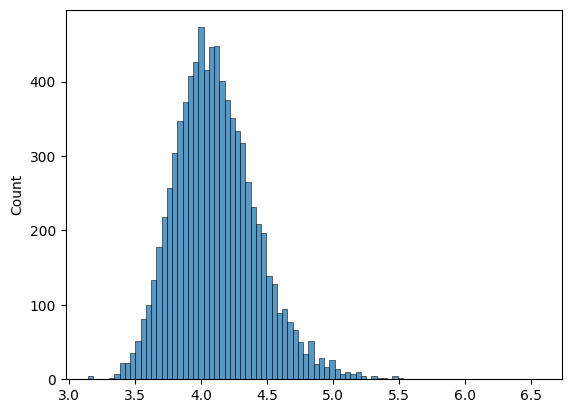

In [54]:
sns.histplot(x=distances[0].numpy())

In [59]:
top_N = 10

In [62]:
nearthest_local_item_ids = torch.argsort(distances, dim=1)[0, :top_N]

In [64]:
item_ids = item_encoder.inverse_transform(nearthest_local_item_ids.numpy())

In [70]:
with pl.Config() as config:
    config.set_fmt_str_lengths(255)
    config.set_tbl_formatting("ASCII_FULL")
    config.set_tbl_hide_column_data_types(True)
    config.set_tbl_rows(-1)
    print(all_item_features.filter(pl.col("item_id").is_in(item_ids)))

shape: (10, 5)
+---------+------------------------------+-----------------------------+--------------------+------+
| item_id | title                        | genres                      | authors            | year |
+==================================================================================================+
| 40391   | триста метров до метро       | научная                     | Александр Прозоров | 1999 |
|         |                              | фантастика,социальная       |                    |      |
|         |                              | фантастика                  |                    |      |
|---------+------------------------------+-----------------------------+--------------------+------|
| 3096    | упавшая с небес, или жить    | остросюжетные любовные      | Юлия Шилова        | 2013 |
|         | страстями приятно            | романы,современные          |                    |      |
|         |                              | детективы                   |    